<a href="https://colab.research.google.com/github/data-alch3m1st/PyTorch_tinkering/blob/main/Circles_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Standard PyTorch imports
import torch
from torch import nn
from sklearn.model_selection import train_test_split

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

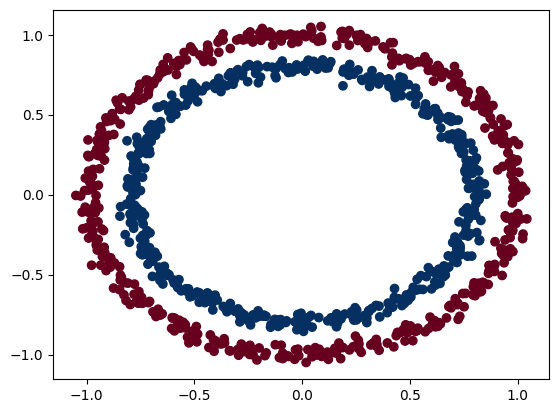

In [8]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=27,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [9]:
# Convert to tensors and split into train and test sets

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=27
    )

X_train[:5], y_train[:5]

(tensor([[ 0.2408, -0.7845],
         [-0.7565,  0.2557],
         [-0.1850,  1.0390],
         [-0.4650, -0.6389],
         [ 0.8216,  0.0856]]),
 tensor([1., 1., 0., 1., 1.]))

In [3]:
from torch import nn

In [10]:
# 2. Define the PyTorch model
class CircleModel(nn.Module):
    def __init__(self):
        super(CircleModel, self).__init__()
        self.layer_1 = nn.Linear(2, 10)  # Input: 2 features, Output: 10 features
        self.layer_2 = nn.Linear(10, 10)  # Input: 10 features, Output: 10 features
        self.out = nn.Linear(10, 1)      # Input: 10 features, Output: 1 (binary classification)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer_1(x)) # Inserts ReLU after layer1
        x = self.relu(self.layer_2(x)) # Inserts ReLU after layer2
        x = self.out(x)  # No activation here because we'll use BCEWithLogitsLoss
        return x

In [11]:
model = CircleModel().to(device)
print(model)

CircleModel(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (out): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [12]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(
    model.parameters()
    , lr=0.1)

In [22]:
# Since PyTorch has the nuances of 'device', sklearn code, while still doable, can be somewhat challenging because of this (e.g., have to write code into any sklearn methods to swtich / stich-back devices;) Hence, it might be more efficient to write a PyTorch compatible function for any sklearn code that presents these challenges;

# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [13]:
from sklearn.metrics import accuracy_score

In [23]:
torch.manual_seed(27)

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000 # Train for longer

# 'For epochs in a range'
for epoch in range(epochs):
  # 'Call model.train()'
    model.train()

    ### Training
    # 1. Forward pass
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss/accuracy *sklearn 'accuracy_score' (requires device mumbo jumbo) -or- 'accuracy_fn' (simpler)
    loss = loss_fn(y_logits, y_train)
    # acc = accuracy_score(y_true=y_train.detach().cpu(), y_pred=y_pred.detach().cpu())
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        # test_acc = accuracy_score(y_true=y_test.detach().cpu(), y_pred=test_pred.detach().cpu())
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.21127, Accuracy: 99.88% | Test loss: 0.22157, Test acc: 99.50%
Epoch: 100 | Loss: 0.13036, Accuracy: 100.00% | Test loss: 0.13845, Test acc: 99.50%
Epoch: 200 | Loss: 0.08574, Accuracy: 100.00% | Test loss: 0.09165, Test acc: 99.50%
Epoch: 300 | Loss: 0.06035, Accuracy: 100.00% | Test loss: 0.06425, Test acc: 100.00%
Epoch: 400 | Loss: 0.04522, Accuracy: 100.00% | Test loss: 0.04804, Test acc: 100.00%
Epoch: 500 | Loss: 0.03561, Accuracy: 100.00% | Test loss: 0.03795, Test acc: 100.00%
Epoch: 600 | Loss: 0.02909, Accuracy: 100.00% | Test loss: 0.03116, Test acc: 100.00%
Epoch: 700 | Loss: 0.02439, Accuracy: 100.00% | Test loss: 0.02631, Test acc: 100.00%
Epoch: 800 | Loss: 0.02087, Accuracy: 100.00% | Test loss: 0.02284, Test acc: 100.00%
Epoch: 900 | Loss: 0.01816, Accuracy: 100.00% | Test loss: 0.02033, Test acc: 100.00%


In [24]:
# Make predictions
model.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model(X_test))).squeeze()

y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([0., 0., 1., 1., 0., 0., 1., 0., 1., 1.], device='cuda:0'),
 tensor([1., 1., 0., 0., 0., 0., 1., 1., 0., 1.]))